In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

C:\Users\alini\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\alini\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Load the provided datasets

In [6]:
data_dir = 'static\lcdp_dataset'
input_dir = os.path.join(data_dir, 'input')
gt_dir = os.path.join(data_dir, 'gt')
valid_input_dir = os.path.join(data_dir, 'valid-input')
valid_gt_dir = os.path.join(data_dir, 'valid-gt')
test_input_dir = os.path.join(data_dir, 'test-input')
test_gt_dir = os.path.join(data_dir, 'test-gt')

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 because original images are very large
    transforms.ToTensor()
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_root, gt_root, transform=None):
        self.input_root = input_root
        self.gt_root = gt_root
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for filename in os.listdir(self.input_root):
            if os.path.isfile(os.path.join(self.input_root, filename)):
                sample = (filename,)
                samples.append(sample)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        filename = self.samples[index][0]
        input_image = Image.open(os.path.join(self.input_root, filename))
        gt_image = Image.open(os.path.join(self.gt_root, filename))
        if self.transform is not None:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
        return input_image, gt_image

# Load the train dataset
train_dataset = CustomDataset(input_dir, gt_dir, transform=data_transform)

# Load the validation dataset
valid_dataset = CustomDataset(valid_input_dir, valid_gt_dir, transform=data_transform)

# Load the test dataset
test_dataset = CustomDataset(test_input_dir, test_gt_dir, transform=data_transform)

# Create data loaders for train, validation, and test datasets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Example on how to use data loader:
for input_train, gt_train in train_loader:
    print(input_train.shape)
    print(gt_train.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


# Part 2. Build the Model Structure

In [8]:
# Define LCDE module

class LCDEModule(nn.Module):
    def __init__(self):
        super(LCDEModule, self).__init__()

        # Define your LCDE module architecture here

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_image):
        x = self.conv1(input_image)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        guided_mask = self.conv3(x)
        guided_mask = self.sigmoid(guided_mask)

        return guided_mask


# Define dual-illumination estimation module
class DualIllumEstimation(nn.Module):
    def __init__(self):
        super(DualIllumEstimation, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 3, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_image):
        x = self.conv1(input_image)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        dual_illumination = self.conv3(x)
        dual_illumination = self.sigmoid(dual_illumination)

        return dual_illumination


class FusionNetwork(nn.Module):
    def __init__(self):
        super(FusionNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x, illumination_1, illumination_2):
        x = self.conv1(x)
        x = self.relu(x)
        x = x * (illumination_1 + illumination_2)  # Element-wise multiplication with the illuminations
        x = self.conv2(x)
        enhanced_image = torch.sigmoid(x)

        return enhanced_image


In [9]:
# Model which uses above modules and networks
import torch.nn.functional as F

class LCDEModel(nn.Module):
    def __init__(self):
        super(LCDEModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.lcde_module = LCDEModule()  # Similar to the lcde module that mentioned in paper
        self.dual_illum_estimation = DualIllumEstimation()  # Similar to the dual illumination estimation network in paper
        self.fusion_network = FusionNetwork()  # Similar to the mentioned fusion network in paper


    def forward(self, input_image):
        guided_mask = self.lcde_module(input_image)

        illuminations = self.dual_illum_estimation(input_image)
        illumination_1 = illuminations[0]
        illumination_2 = illuminations[1]

        # Incorporate the guided mask and illuminations into the network architecture
        x = self.encoder(input_image)
        guided_mask_resized = F.interpolate(guided_mask, size=x.size()[2:], mode='bilinear', align_corners=False)
        x = x * guided_mask_resized  # Element-wise multiplication with the resized guided mask
        x = self.decoder(x)
        enhanced_image = x * (illumination_1 + illumination_2)  # Element-wise multiplication with the illuminations

        return enhanced_image


# Part 3. Train the model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
model = LCDEModel().to(device)

In [12]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
criterion = nn.MSELoss() ## Using MSE loss function, its also mentioned in the paper

In [14]:
num_epochs = 50

In [17]:
load_our_alrdy_trained_model = False
if load_our_alrdy_trained_model:
    model = model.load_state_dict(torch.load("pretrained_models/trained_model.pth", map_location=torch.device('cpu')))
    # if you_are loading this, next loss cells won't work, you can skip them.

In [18]:
from tqdm import tqdm

train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images in tqdm(train_loader):
        input_images = images[0].to(device)
        gt_images = images[1].to(device)

        optimizer.zero_grad()
        enhanced_images = model(input_images)
        loss = criterion(enhanced_images, gt_images)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Compute validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images in tqdm(valid_loader):
            input_images = images[0].to(device)
            gt_images = images[1].to(device)

            enhanced_images = model(input_images)
            loss = criterion(enhanced_images, gt_images)
            val_loss += loss.item()

    val_loss /= len(valid_loader)
    val_losses.append(val_loss)

    test_loss = 0.0
    with torch.no_grad():
        for images in tqdm(test_loader):
            input_images = images[0].to(device)
            gt_images = images[1].to(device)

            enhanced_images = model(input_images)
            loss = criterion(enhanced_images, gt_images)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Save losses to file
    with open("losses.txt", "w+") as file:
        file.write(f"Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}\n")

    # Print losses to console
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

print("Training finished")


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


Epoch [1/50], Train Loss: 0.0896, Val Loss: 0.0883, Test Loss: 0.0904


100%|██████████| 4/4 [00:17<00:00,  4.50s/it]


Epoch [2/50], Train Loss: 0.0824, Val Loss: 0.0819, Test Loss: 0.0834


100%|██████████| 4/4 [00:17<00:00,  4.48s/it]


Epoch [3/50], Train Loss: 0.0744, Val Loss: 0.0747, Test Loss: 0.0754


100%|██████████| 4/4 [00:17<00:00,  4.46s/it]


Epoch [4/50], Train Loss: 0.0659, Val Loss: 0.0664, Test Loss: 0.0665


100%|██████████| 4/4 [00:17<00:00,  4.50s/it]


Epoch [5/50], Train Loss: 0.0581, Val Loss: 0.0602, Test Loss: 0.0597


100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


Epoch [6/50], Train Loss: 0.0516, Val Loss: 0.0548, Test Loss: 0.0539


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [7/50], Train Loss: 0.0473, Val Loss: 0.0505, Test Loss: 0.0494


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [8/50], Train Loss: 0.0442, Val Loss: 0.0473, Test Loss: 0.0458


100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


Epoch [9/50], Train Loss: 0.0412, Val Loss: 0.0459, Test Loss: 0.0437


100%|██████████| 4/4 [00:18<00:00,  4.52s/it]


Epoch [10/50], Train Loss: 0.0400, Val Loss: 0.0431, Test Loss: 0.0413


100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


Epoch [11/50], Train Loss: 0.0381, Val Loss: 0.0417, Test Loss: 0.0397


100%|██████████| 4/4 [00:18<00:00,  4.57s/it]


Epoch [12/50], Train Loss: 0.0366, Val Loss: 0.0403, Test Loss: 0.0382


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [13/50], Train Loss: 0.0351, Val Loss: 0.0391, Test Loss: 0.0369


100%|██████████| 4/4 [00:18<00:00,  4.52s/it]


Epoch [14/50], Train Loss: 0.0338, Val Loss: 0.0380, Test Loss: 0.0357


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [15/50], Train Loss: 0.0327, Val Loss: 0.0368, Test Loss: 0.0346


100%|██████████| 4/4 [00:18<00:00,  4.53s/it]


Epoch [16/50], Train Loss: 0.0315, Val Loss: 0.0357, Test Loss: 0.0334


100%|██████████| 4/4 [00:17<00:00,  4.48s/it]


Epoch [17/50], Train Loss: 0.0306, Val Loss: 0.0346, Test Loss: 0.0325


100%|██████████| 4/4 [00:18<00:00,  4.50s/it]


Epoch [18/50], Train Loss: 0.0290, Val Loss: 0.0335, Test Loss: 0.0312


100%|██████████| 4/4 [00:18<00:00,  4.60s/it]


Epoch [19/50], Train Loss: 0.0275, Val Loss: 0.0326, Test Loss: 0.0301


100%|██████████| 4/4 [00:18<00:00,  4.53s/it]


Epoch [20/50], Train Loss: 0.0266, Val Loss: 0.0317, Test Loss: 0.0291


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [21/50], Train Loss: 0.0255, Val Loss: 0.0308, Test Loss: 0.0281


100%|██████████| 4/4 [00:17<00:00,  4.47s/it]


Epoch [22/50], Train Loss: 0.0244, Val Loss: 0.0300, Test Loss: 0.0272


100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


Epoch [23/50], Train Loss: 0.0238, Val Loss: 0.0293, Test Loss: 0.0266


100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


Epoch [24/50], Train Loss: 0.0222, Val Loss: 0.0286, Test Loss: 0.0257


100%|██████████| 4/4 [00:18<00:00,  4.57s/it]


Epoch [25/50], Train Loss: 0.0216, Val Loss: 0.0279, Test Loss: 0.0248


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


Epoch [26/50], Train Loss: 0.0209, Val Loss: 0.0272, Test Loss: 0.0242


100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


Epoch [27/50], Train Loss: 0.0206, Val Loss: 0.0269, Test Loss: 0.0237


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [28/50], Train Loss: 0.0197, Val Loss: 0.0265, Test Loss: 0.0234


100%|██████████| 4/4 [00:17<00:00,  4.43s/it]


Epoch [29/50], Train Loss: 0.0191, Val Loss: 0.0260, Test Loss: 0.0227


100%|██████████| 4/4 [00:18<00:00,  4.57s/it]


Epoch [30/50], Train Loss: 0.0186, Val Loss: 0.0255, Test Loss: 0.0221


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [31/50], Train Loss: 0.0181, Val Loss: 0.0252, Test Loss: 0.0218


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [32/50], Train Loss: 0.0175, Val Loss: 0.0249, Test Loss: 0.0215


100%|██████████| 4/4 [00:18<00:00,  4.57s/it]


Epoch [33/50], Train Loss: 0.0177, Val Loss: 0.0246, Test Loss: 0.0211


100%|██████████| 4/4 [00:18<00:00,  4.58s/it]


Epoch [34/50], Train Loss: 0.0173, Val Loss: 0.0244, Test Loss: 0.0209


100%|██████████| 4/4 [00:17<00:00,  4.47s/it]


Epoch [35/50], Train Loss: 0.0167, Val Loss: 0.0242, Test Loss: 0.0207


100%|██████████| 4/4 [00:17<00:00,  4.48s/it]


Epoch [36/50], Train Loss: 0.0163, Val Loss: 0.0240, Test Loss: 0.0205


100%|██████████| 4/4 [00:17<00:00,  4.46s/it]


Epoch [37/50], Train Loss: 0.0163, Val Loss: 0.0237, Test Loss: 0.0201


100%|██████████| 4/4 [00:18<00:00,  4.54s/it]


Epoch [38/50], Train Loss: 0.0160, Val Loss: 0.0235, Test Loss: 0.0200


100%|██████████| 4/4 [00:17<00:00,  4.48s/it]


Epoch [39/50], Train Loss: 0.0161, Val Loss: 0.0234, Test Loss: 0.0199


100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


Epoch [40/50], Train Loss: 0.0159, Val Loss: 0.0234, Test Loss: 0.0197


100%|██████████| 4/4 [00:18<00:00,  4.58s/it]


Epoch [41/50], Train Loss: 0.0152, Val Loss: 0.0229, Test Loss: 0.0193


100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


Epoch [42/50], Train Loss: 0.0151, Val Loss: 0.0229, Test Loss: 0.0192


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Epoch [43/50], Train Loss: 0.0149, Val Loss: 0.0229, Test Loss: 0.0195


100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


Epoch [44/50], Train Loss: 0.0152, Val Loss: 0.0227, Test Loss: 0.0193


100%|██████████| 4/4 [00:17<00:00,  4.46s/it]


Epoch [45/50], Train Loss: 0.0150, Val Loss: 0.0225, Test Loss: 0.0188


100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


Epoch [46/50], Train Loss: 0.0149, Val Loss: 0.0223, Test Loss: 0.0185


100%|██████████| 4/4 [00:18<00:00,  4.55s/it]


Epoch [47/50], Train Loss: 0.0146, Val Loss: 0.0222, Test Loss: 0.0185


100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


Epoch [48/50], Train Loss: 0.0148, Val Loss: 0.0221, Test Loss: 0.0185


100%|██████████| 4/4 [00:17<00:00,  4.48s/it]


Epoch [49/50], Train Loss: 0.0146, Val Loss: 0.0221, Test Loss: 0.0184


100%|██████████| 4/4 [00:18<00:00,  4.52s/it]

Epoch [50/50], Train Loss: 0.0142, Val Loss: 0.0219, Test Loss: 0.0182
Training finished


In [19]:
# save my alrdy trained model
save_path = "trained_model_2.pth"
torch.save(model.state_dict(), save_path)

# Part 4. Analyse trained model

## Part 4.1 Loss Curves of Training, Validation and Test Sets

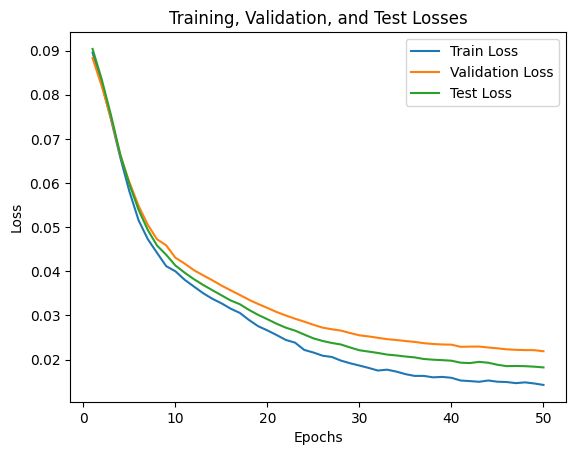

In [20]:
import matplotlib.pyplot as plt

# Plot losses
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()


# Part 4.2 Test Trained Model on a Test Image, Check result visually

(64, 224, 224, 3)


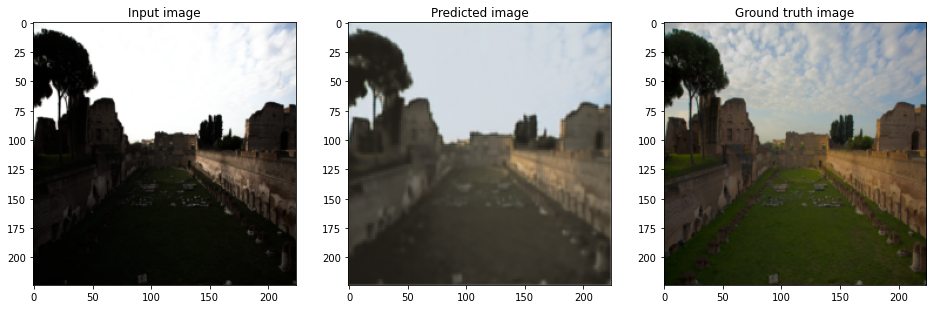

In [21]:
import matplotlib.pyplot as plt
import random
pick_one = 0 # 0-63

# Load the model
model_state_dict = torch.load('pretrained_models/trained_model.pth', map_location=torch.device('cpu')) # cpu or cuda
model = LCDEModel()
model.load_state_dict(model_state_dict)

# Get the first item from the test loader (input image)
input_image, ground_truth_image = next(iter(test_loader))

# Set the model to evaluation mode
model.eval()

# Pass the input image through the model
with torch.no_grad():
    enhanced_image = model(input_image)

# Convert the output tensor to a numpy array
enhanced_image = enhanced_image.permute(0, 2, 3, 1).numpy()

# Visualize or save the enhanced image
print(enhanced_image.shape)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,9))

ax1.imshow(input_image[pick_one].permute(1,2,0).numpy())
ax2.imshow(enhanced_image[pick_one])
ax3.imshow(ground_truth_image[pick_one].permute(1, 2, 0).numpy())

ax1.set_title("Input image")
ax2.set_title("Predicted image")
ax3.set_title("Ground truth image")
plt.show()
